In [1]:
import time
import torchvision
from torchvision import  transforms
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import week3.task1.newtask.pytorch_utils as pytorch_utils

1.4166390895843506
iou: 0.7988033753845285
iou: 0.0
1 0


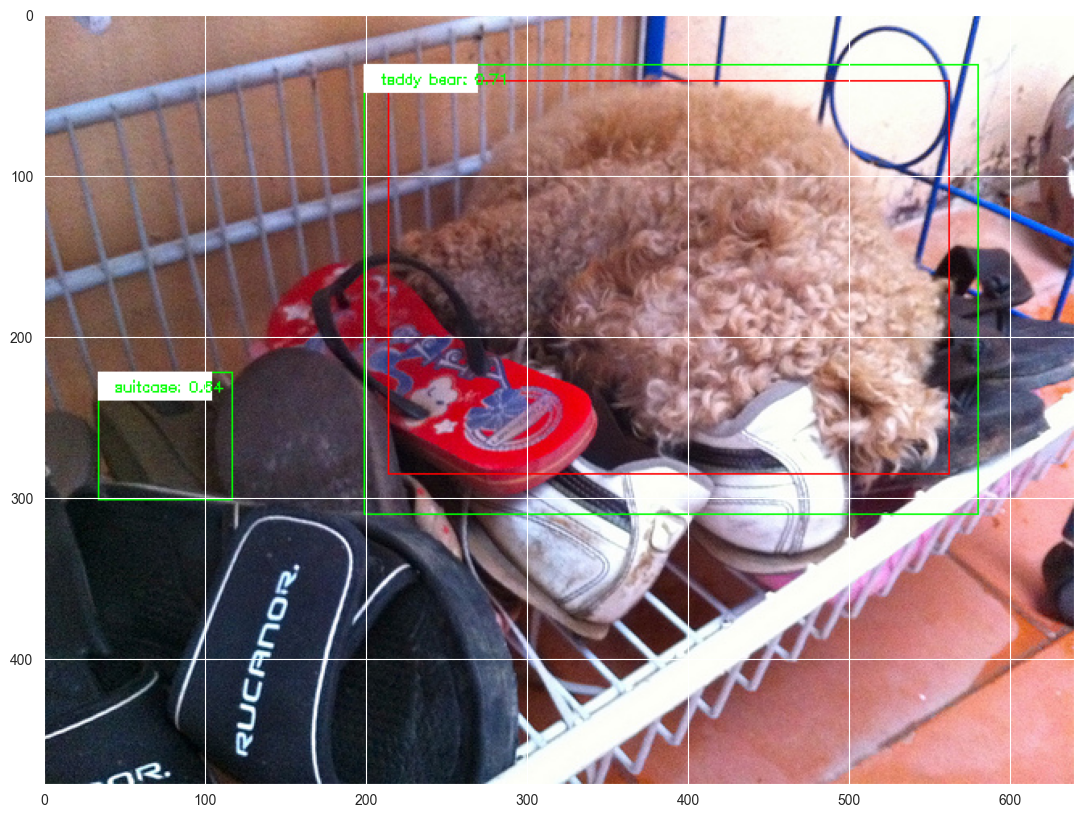

2.4348089694976807
iou: 0.0
iou: 0.0
iou: 0.6068328716528163
iou: 0.6119916804131105
iou: 0.0
iou: 0.0
iou: 0.9232152490559252
iou: 0.410010649627263
iou: 0.0
iou: 0.899312310981835
iou: 0.0
iou: 0.0
iou: 0.9319862890131697
iou: 0.0
iou: 0.0
iou: 0.0
5 4


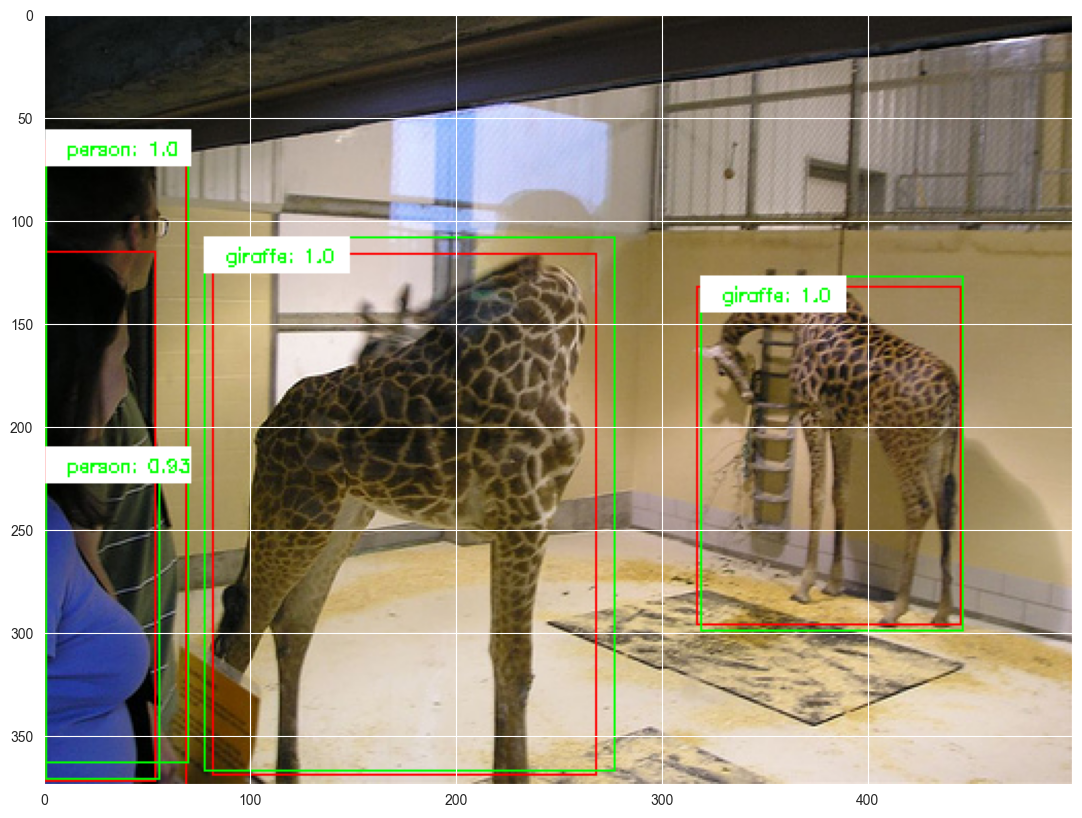

3.4585609436035156
iou: 0.0
iou: 0.8461538461538461
iou: 0.19518072289156627
iou: 0.0
iou: 0.26268115942028986
iou: 0.8503468780971258
iou: 0.8983666061705989
iou: 0.0
iou: 0.0
8 7


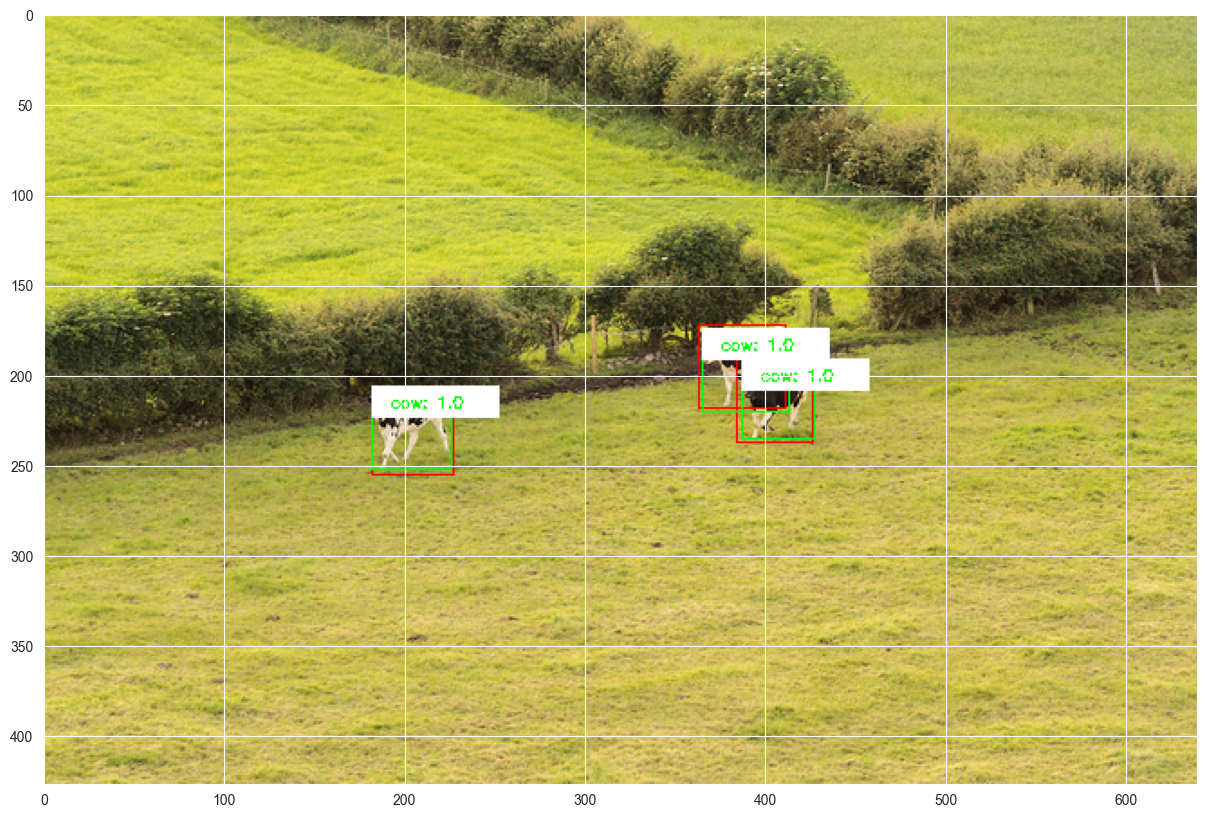

4.494579792022705
iou: 0.9415548098434005
iou: 0.0
iou: 0.0015697018993392983
iou: 0.0
iou: 0.8344827586206897
iou: 0.0
10 9


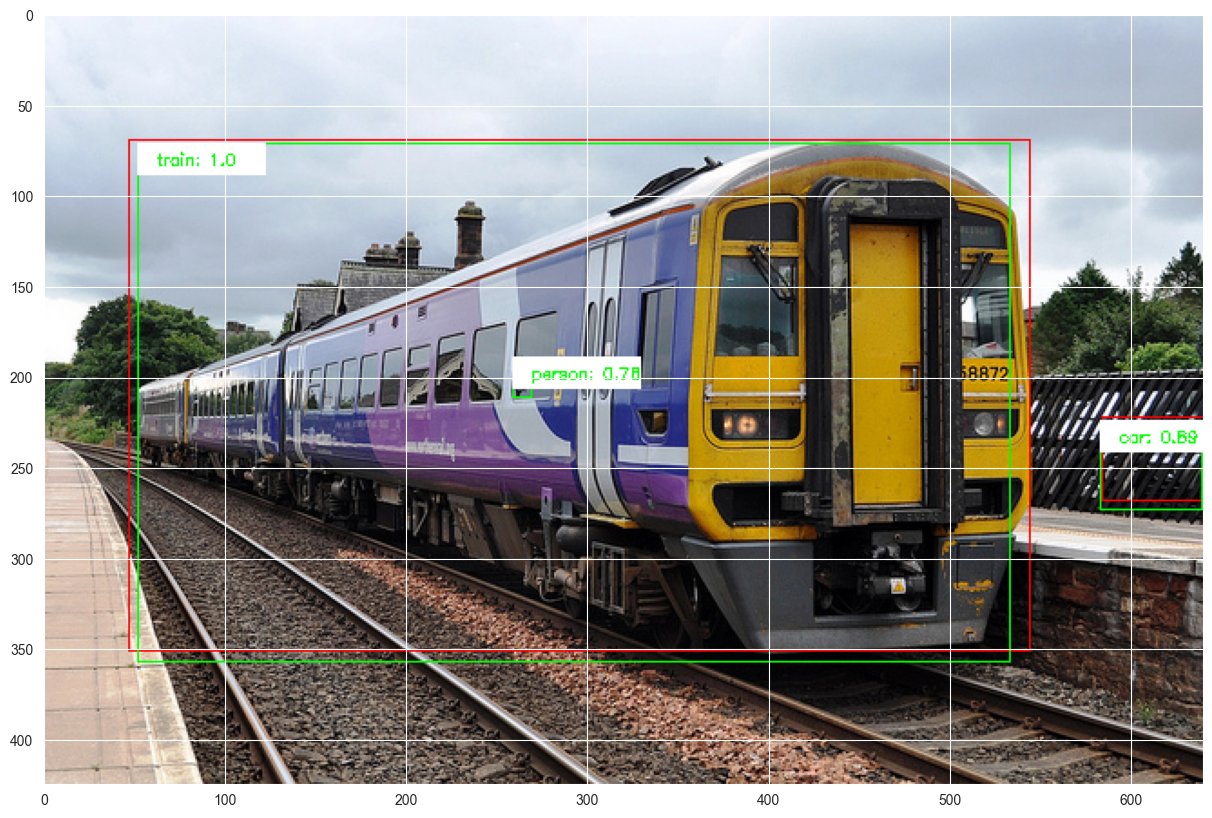

5.476894378662109
iou: 0.9427168576104746
iou: 0.03272339592263006
iou: 0.01865471997955647
iou: 0.028193134223196463
iou: 0.8660848100149873
iou: 0.39031236248161466
iou: 0.016147118187934514
iou: 0.3014754098360656
iou: 0.8383045525902669
13 11


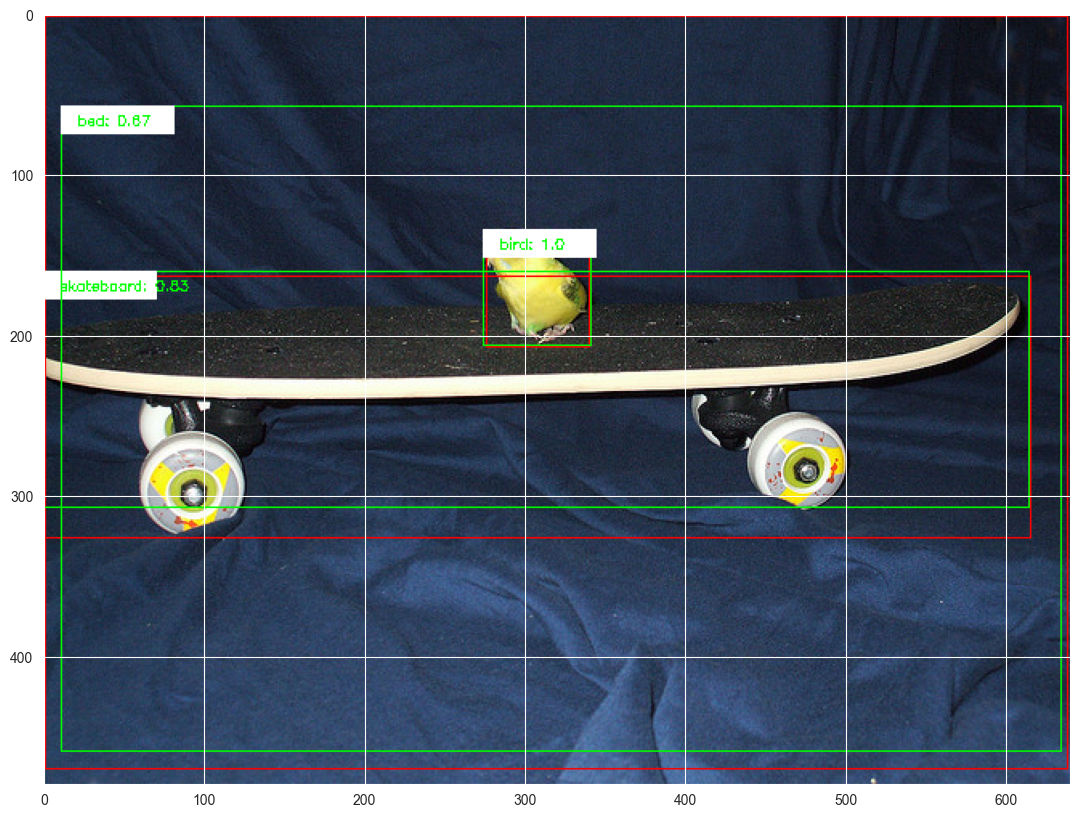

13 11
accuracy: 0.8461538461538461


In [29]:
def coord_calculator(x, y, w, h, ih, iw):
        x1 = (x - (w / 2)) * iw
        x2 = (x + (w / 2)) * iw
        y1 = (y - (h / 2)) * ih
        y2 = (y + (h / 2)) * ih
        return round(x1), round(y1), round(x2), round(y2)

COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
        'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
        'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
        'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

img_dir = '/Users/ashleycui/data/coco2014/val2014/'
anno_dir = '/Users/ashleycui/data/txt/'
fs = ['COCO_val2014_000000000042.jpg',
        'COCO_val2014_000000000136.jpg',
        'COCO_val2014_000000001083.jpg',
      'COCO_val2014_000000001374.jpg',
      'COCO_val2014_000000001561.jpg'
]

half = 0.5
duration = 0
total = correct = 0
for ig in fs:
        # model
        model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
        model_.eval()
        for name, param in model_.named_parameters():
                # freezing the part of the model as no changes happen to its parameters
                param.requires_grad = False
        def model(x):
                with torch.no_grad():
                        yhat = model_(x)
                return yhat
        
        # getting image
        img_path = img_dir + ig
        image = Image.open(img_path)
        image.resize([int(half * s) for s in image.size])
        dims = image.size
        transform = transforms.Compose([transforms.ToTensor()])
        img = transform(image)
        
        # getting pred
        start = time.time()
        pred = model([img])
        end = time.time()
        duration += (end - start)
        print(duration)
        
        pred_thresh = pytorch_utils.get_predictions(pred, threshold=0.5)
        # pytorch_utils.draw_box(pred_thresh, img, rect_th=1, text_size= 0.5, text_th=1)
        img = (np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

        # reading txt file 
        
        anno_file = anno_dir + ig.split('.')[0] + '.txt'
        with open(anno_file,'r') as f:
                for line in f.readlines():
                        segs = line.split()
                        clz = int(segs[0]) + 1
                        cx, cy = float(segs[1]), float(segs[2])
                        w, h = float(segs[3]), float(segs[4])

                        x1, y1, x2, y2 = coord_calculator(cx, cy, w, h, dims[1], dims[0])
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 1)

                        text_size= 0.3
                        text_th=1
                        
                        maxiou = 0
                        labelx = None
                        
                        for predicted_class in pred_thresh:
                                label = predicted_class[0]
                                probability = predicted_class[1]
                                box = predicted_class[2]
                                t = round(box[0][0].tolist())
                                l = round(box[0][1].tolist())
                                r = round(box[1][0].tolist())
                                b = round(box[1][1].tolist())
                                
                                iou = pytorch_utils.get_iou({'x1':x1, 'x2':x2, 'y1':y1, 'y2':y2}, {'x1':t, 'x2':r, 'y1':l, 'y2':b})
                                print(f'iou: {iou}')
                                maxiou = max(maxiou, iou)

                                cv2.rectangle(img, (t, l), (r, b), (0, 255, 0), 1)
                                cv2.rectangle(img, (t, l), (t+70, l+17), (255, 255, 255), -1)
                                cv2.putText(img, label+": "+str(round(probability, 2)), (t+10, l+12),  cv2.FONT_HERSHEY_SIMPLEX,
                                            text_size, (0,255,0), thickness=text_th)
                                # cv2.putText(img, label+": "+str(round(probability, 2)),
                                #             (x1+10, y1+12),  cv2.FONT_HERSHEY_SIMPLEX, text_size,
                                #             (0, 255, 0),thickness=text_th)
                                if maxiou == iou:
                                        labelx = label
                                
                        label2 = COCO_INSTANCE_CATEGORY_NAMES[clz]
                        if label2 == labelx:
                                correct += 1
                        total += 1
        print(f'{total} {correct}')
        # print(f'accuracy: {correct / total}')
        img = np.array(img)
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # if download_image:
        #     # plt.savefig(f'{img_name}.png')
        # else:
        #     pass
        plt.show()
print(f'{total} {correct}')
print(f'accuracy: {correct / total}')